# Code from previos notebooks

In [ ]:
! pip3 install tiktoken

In [ ]:
with open("/content/Build-a-Large-Language-Model-_From-Scratch_-.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 420297
Build a Large Language Model (From Scratch)
 1.   welcome
 2.   1_Understanding_Large_Language_Mo


In [ ]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [ ]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [ ]:
import tiktoken

encodings = {
    "gpt2": tiktoken.get_encoding("gpt2"),
    "gpt3": tiktoken.get_encoding("p50k_base"),  # Commonly associated with GPT-3 models
    "gpt4": tiktoken.get_encoding("cl100k_base")  # Used for GPT-4 and later versions
}

vocab_sizes = {model: encoding.n_vocab for model, encoding in encodings.items()}

for model, size in vocab_sizes.items():
    print(f"The vocabulary size for {model.upper()} is: {size}")

The vocabulary size for GPT2 is: 50257
The vocabulary size for GPT3 is: 50281
The vocabulary size for GPT4 is: 100277


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [ ]:
from torch import nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

# GPT architecture

In [ ]:
import torch
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(normalized_shape))
        self.shift = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        x = x.float()
        mean = torch.mean(x, dim=-1, keepdim=True)
        var = torch.var(x, dim=-1, unbiased=False, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return norm_x

class DummyGPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(*[\
        DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_emb = self.tok_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_emb + pos_emb
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Step 1 tokenize

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


## Step 2 create gpt model

In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9387, -0.1849,  0.9918,  ...,  0.4882, -0.4199,  0.2883],
         [-0.1423, -1.5278, -1.2965,  ...,  0.1831, -0.6640,  1.1918],
         [ 0.6305, -1.2153, -0.6739,  ..., -0.2186,  1.0443,  0.1485],
         [ 0.2694,  0.7718, -0.2499,  ..., -0.1354, -0.3372,  0.3116]],

        [[-0.5045, -0.9002,  1.2517,  ...,  0.5607,  0.1657,  0.6505],
         [ 0.1482, -0.8394, -1.0867,  ...,  0.5817, -0.3435,  1.4208],
         [ 1.0458, -0.3748, -0.4090,  ..., -0.4537, -0.2106,  0.0752],
         [ 0.7881,  0.5017,  0.1975,  ..., -0.1680, -0.3160,  0.3841]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
ln = DummyLayerNorm(normalized_shape=5)
out_ln = ln(batch)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.],
        [0.]])
Variance:
 tensor([[1.0000],
        [1.0000]])


In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(normalized_shape))
        self.shift = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        x = x.float()
        mean = torch.mean(x, dim=-1, keepdim=True)
        var = torch.var(x, dim=-1, unbiased=False, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return norm_x

## Feed forward with GELU

In [ ]:
class GELU(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"]*4),
            GELU(),
            nn.Linear(cfg["emb_dim"]*4, cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layer(x)

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## Shortcut connection

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList()

        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Sequential(
                nn.Linear(layer_sizes[i], layer_sizes[i+1]),
                GELU()
            ))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            output = layer(x)

            if self.use_shortcut and i > 0 and x.shape == output.shape:
                x = x + output
            else:
                x = output

        return x

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

In [ ]:
def print_gradients(model, x):
    torch.autograd.set_detect_anomaly(True)

    try:
        model.zero_grad()

        output = model(x)
        target = torch.tensor([[0.]], device=x.device)

        loss_fn = nn.MSELoss()
        loss = loss_fn(output, target)

        loss.backward()

        for name, param in model.named_parameters():
            if 'weight' in name and param.grad is not None:
                print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

    except Exception as e:
        print(f"Error during backward: {e}")
    finally:
        torch.autograd.set_detect_anomaly(False)

In [ ]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [ ]:
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0040627289563417435
layers.1.0.weight has gradient mean of 0.002765689278021455
layers.2.0.weight has gradient mean of 0.0014848874416202307
layers.3.0.weight has gradient mean of 0.0038529506418854
layers.4.0.weight has gradient mean of 0.028034919872879982


## Transformer block

In [88]:
import torch
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"], cfg["drop_rate"], cfg["n_heads"])
        self.ff = FeedForward(cfg)
        self.layer_norm1 = LayerNorm(cfg["emb_dim"])
        self.layer_norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        self.gelu = GELU()

    def forward(self, x):
        shortcut = x
        x = self.layer_norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)

        x = x + shortcut
        shortcut = x
        x = self.layer_norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## GPT class

In [ ]:
class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_emb = self.tok_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_emb + pos_emb
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [98]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [ ]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## Text generation

In [ ]:
def simple_text_generate(model, idx, max_new_tokens, context_length):

    model.eval()
    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_length:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        next_idx = torch.argmax(probas, dim=1, keepdim=True)
        idx = torch.cat((idx, next_idx), dim=1)

    return idx

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval() #A
out = simple_text_generate(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_length=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


## Loss function

In [ ]:
import tiktoken

def text2ids(text, tokenizer):
    tokens = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    tokens_batch = torch.tensor(tokens).unsqueeze(0)
    return tokens_batch

def ids2text(ids, tokenizer):
    flat = ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = simple_text_generate(
    model=model,
    idx=text2ids(start_context, tokenizer),
    max_new_tokens=10,
    context_length=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", ids2text(token_ids, tokenizer))

Output text:
 Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate


In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [ ]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[36397],
         [39619],
         [20610]],

        [[ 8615],
         [49289],
         [47105]]])


In [ ]:
print(f"Targets batch 1: {ids2text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {ids2text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Gathering SerbianFriday


Cross-entropy loss

In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([2.3466e-05, 2.0531e-05, 1.1733e-05])
Text 2: tensor([4.2794e-05, 1.6248e-05, 1.1586e-05])


In [ ]:
log_probs = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probs)

tensor([-10.6600, -10.7936, -11.3531, -10.0591, -11.0276, -11.3658])


In [ ]:
neg_avg_log_probs = -1 * torch.mean(log_probs)
print(neg_avg_log_probs)

tensor(10.8765)


In [ ]:
print("Logits shape:", logits.shape)

print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8765)


In [ ]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(52918.7773)


## Train and validation losses

In [ ]:
all_text = raw_text[50000:]
train_ratio = 0.9
train_ids = int(train_ratio * len(all_text))
val_ids = int((1 - train_ratio) * len(all_text))

train_data = all_text[:train_ids]
val_data = all_text[-val_ids:]

In [ ]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
if len(train_data) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if len(val_data) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 102

In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 98304
Validation tokens: 11264
All tokens: 109568


In [ ]:
from tqdm import tqdm
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in tqdm(enumerate(data_loader)):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

48it [13:09, 16.45s/it]
6it [01:28, 14.79s/it]

Training loss: 10.978019615014395
Validation loss: 10.973168214162191


## Training loop

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text2ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = simple_text_generate(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = ids2text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, train_batch in train_loader:
            model.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

            generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [76]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
start_time = time.time()
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)

num_epochs = 3
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
train_period = (end_time - start_time) / 60
print(f"Training completed in {train_period:.2f} minutes")

NameError: name 'train_model_simple' is not defined

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
model.to("cpu")
model.eval()

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = simple_text_generate(
    model,
    tokenizer.encode("Every effort moves you"),
    max_new_tokens=25,
    context_length=GPT_CONFIG_124M['context_length']
)
print(f"Output text for sample: {ids2text(token_ids, tokenizer)}")

## Temperature scalling

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [ ]:
probas = torch.nn.functional.softmax(next_token_logits, dim=-1)
next_token = torch.argmax(probas).item()
print(inverse_vocab[next_token])

forward


In [ ]:
torch.manual_seed(123)
next_token = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token])

forward


In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    samples = [torch.multinomial(probas, num_samples=1) for _ in range(1000)]
    freq_ids = torch.bincount(torch.tensor(samples))
    for i, freq in enumerate(freq_ids):
        print(f"{freq} X {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 X closer
0 X every
0 X effort
582 X forward
2 X inches
0 X moves
0 X pizza
343 X toward


In [ ]:
def softmax_with_temperature(logits, temperature):
    scalled_logits = logits / temperature
    return torch.nn.functional.softmax(scalled_logits)

temperatures = [0.1, 5, 1]
probas_with_t = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

/tmp/ipython-input-489690221.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(scalled_logits)


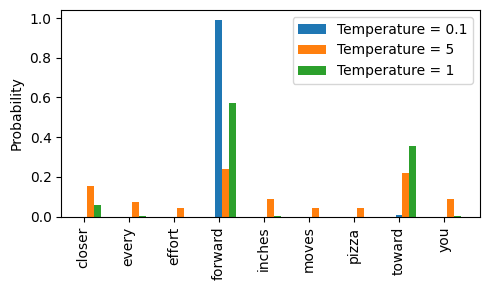

In [ ]:
import matplotlib.pyplot as plt

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, probas_with_t[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

## Top-k sampling

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, k=top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [68]:
new_logits = next_token_logits.where(
    condition=next_token_logits>=top_logits[-1],
    other=torch.tensor(float("-inf"))
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [70]:
topk_probas = torch.softmax(new_logits, dim=-1)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [71]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [73]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text2ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", ids2text(token_ids, tokenizer))

Output text:
 Every effort moves you JCFord Run Rates gorePutting Settlement 330encingSee Cruiser41 international donatedabsolute


## Save and load model

In [77]:
torch.save(
    {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict()
    },
    "gpt_state.pth"
)

In [96]:
model = torch.load("gpt_state.pth")["model"]
optimizer = torch.load("gpt_state.pth")["optimizer"]

Load pre-trained weights gpt2

In [102]:
!pip install transformers

In [103]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_weights = AutoModelForCausalLM.from_pretrained("gpt2")
gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]